In [15]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from torchsummary import summary
import onnx
import onnxruntime
import tensorflow_addons as tfa
from onnx_tf.backend import prepare
import sys
import os
from tqdm import tqdm

mydevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(mydevice)

cpu


# train a convnet model

In [9]:
# light model for mnist
# convnet = nn.Sequential( nn.Conv2d(1,1,3), nn.ReLU(), nn.Conv2d(1,1,3), nn.ReLU(), nn.Flatten(), nn.Linear(24*24,10) ).to(mydevice)
# convnet = nn.Sequential( nn.Conv2d(1,1,5), nn.ReLU(), nn.Conv2d(1,1,5), nn.ReLU(),nn.Conv2d(1,1,5), nn.ReLU(),nn.Conv2d(1,1,5), nn.ReLU(),nn.Conv2d(1,1,5), nn.ReLU(),
#  nn.Flatten(), nn.Linear(8*8,64), nn.ReLU(),nn.Linear(64,10)).to(mydevice)
class resnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.rel = nn.ReLU()
        self.conv0 = nn.Conv2d(1,1,7) # 22*22
        self.conv1 = nn.Conv2d(1,1,3, padding=1)
        self.conv2 = nn.Conv2d(1,1,3, padding=1)
        self.conv3 = nn.Conv2d(1,1,3, padding=1)
        self.conv4 = nn.Conv2d(1,1,5)            # 18*18
        self.conv5 = nn.Conv2d(1,1,3, padding=1)
        self.conv6 = nn.Conv2d(1,1,3, padding=1)
        self.conv7 = nn.Conv2d(1,1,3, padding=1)
        self.conv8 = nn.Conv2d(1,1,5)           # 16*16
        self.conv9 = nn.Conv2d(1,1,3, padding=1)
        self.conv10 = nn.Conv2d(1,1,3, padding=1)
        self.conv11 = nn.Conv2d(1,1,3, padding=1)
        self.conv12 = nn.Conv2d(1,1,5)         # 12*12
        self.fc1 = nn.Linear(100, 10)
    
    def forward(self, x):
        x = self.rel(self.conv0(x))
        x1 = self.rel(self.conv1(x))
        x2 = self.rel(self.conv2(x1))
        x3 = self.rel(self.conv3(x2))
        x = x + x3
        x = self.rel(self.conv4(x))
        x1 = self.rel(self.conv5(x))
        x2 = self.rel(self.conv6(x1))
        x3 = self.rel(self.conv7(x2))
        x = x + x3
        x = self.rel(self.conv8(x))
        x1 = self.rel(self.conv9(x))
        x2 = self.rel(self.conv10(x1))
        x3 = self.rel(self.conv11(x2))
        x = x + x3
        x = self.rel(self.conv12(x))
        # x = x.view(-1, 12*12)
        x = nn.Flatten()(x)
        # print(x.shape)
        x = self.fc1(x)
        return x

convnet = resnet().to(mydevice)
# convnet = nn.Sequential( nn.Flatten(), nn.Linear(28*28, 256), nn.ReLU(), nn.Linear(256, 100), nn.ReLU(), nn.Linear(100,10) ).to(mydevice)

#  print the operators
summary(convnet, (1,28,28))
# summary(mlp, (1,28,28))

optim = torch.optim.AdamW(convnet.parameters(), lr=0.01)
critereon = nn.CrossEntropyLoss().to(mydevice)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, verbose=True)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 22, 22]              50
              ReLU-2            [-1, 1, 22, 22]               0
            Conv2d-3            [-1, 1, 22, 22]              10
              ReLU-4            [-1, 1, 22, 22]               0
            Conv2d-5            [-1, 1, 22, 22]              10
              ReLU-6            [-1, 1, 22, 22]               0
            Conv2d-7            [-1, 1, 22, 22]              10
              ReLU-8            [-1, 1, 22, 22]               0
            Conv2d-9            [-1, 1, 18, 18]              26
             ReLU-10            [-1, 1, 18, 18]               0
           Conv2d-11            [-1, 1, 18, 18]              10
             ReLU-12            [-1, 1, 18, 18]               0
           Conv2d-13            [-1, 1, 18, 18]              10
             ReLU-14            [-1, 1,

In [10]:
batchsize = 64

# load MNIST data
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=T.ToTensor())
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=T.ToTensor())

# split into train and validation
total_data = 0.5
val_length = int(len(train_set)*0.1)
train_length = int(len(train_set)) - val_length
train_set, val_set = torch.utils.data.random_split(train_set, [train_length, val_length])
train_set, _ = torch.utils.data.random_split(train_set, [int(len(train_set)*total_data), len(train_set)-int(len(train_set)*total_data)])
val_set, _ = torch.utils.data.random_split(val_set, [int(len(val_set)*total_data), len(val_set)-int(len(val_set)*total_data)])
test_set, _ = torch.utils.data.random_split(test_set, [int(len(test_set)*total_data), len(test_set)-int(len(test_set)*total_data)])
# train_set, val_set = torch.utils.data.random_split(train_set, [train_length, val_length])
# test_set, _ = torch.utils.data.random_split(test_set, [test_length, len(test_set)-test_length])


# create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batchsize, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batchsize, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batchsize, shuffle=False)

#  print all the info sizes
print("train set size: ", len(train_set))
print("validation set size: ", len(val_set))
print("test set size: ", len(test_set))
print("train loader size: ", len(train_loader))
print("validation loader size: ", len(val_loader))
print("test loader size: ", len(test_loader))

#  print distribution of classes
def print_class_distribution(loader):
    class_count = [0 for i in range(10)]
    for batch in loader:
        for label in batch[1]:
            class_count[label] += 1
    print(class_count)

print("train set class distribution:")
print_class_distribution(train_loader)
print("validation set class distribution:")
print_class_distribution(val_loader)
print("test set class distribution:")
print_class_distribution(test_loader)


train set size:  27000
validation set size:  3000
test set size:  5000
train loader size:  422
validation loader size:  47
test loader size:  79
train set class distribution:
[2686, 3032, 2725, 2767, 2653, 2422, 2667, 2819, 2650, 2579]
validation set class distribution:
[312, 339, 270, 308, 306, 252, 294, 310, 273, 336]
test set class distribution:
[470, 576, 498, 509, 507, 469, 471, 505, 484, 511]


In [11]:

best_loss = np.inf

train_losses = []
tain_accs = []
test_losses = []
test_accs = []

weights = []
biases = []
grads = []


# train
for epoch in tqdm(range(20)):
    convnet.train()
    total_loss = 0
    total_acc = 0
    with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
        for x, y in train_loader:
            pbar.update(1)
            x = x.to(mydevice)
            y = y.to(mydevice)
            optim.zero_grad(set_to_none = True)
            y_ = convnet(x)
            loss = critereon(y_, y)
            total_acc += (y_.argmax(dim=1) == y).sum().item()
            loss.backward()
            optim.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))
        tain_accs.append(total_acc / len(train_set))
        # print(f"epoch {epoch} train loss {total_loss / len(train_loader)}")
        pbar.set_description(f"epoch {epoch} train acc {total_acc / len(train_set):.3f}")
        pbar.refresh()
    # if epoch % 2 == 0:
    #     weights.append(convnet[0].weight.detach().cpu().numpy())
    #     biases.append(convnet[0].bias.detach().cpu().numpy())
    #     grads.append(convnet[0].weight.grad.detach().cpu().numpy())
    
    # test
    convnet.eval()
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        with tqdm(total=len(test_loader), file=sys.stdout) as pbar:
            for x, y in test_loader:
                pbar.update(1)
                x = x.to(mydevice)
                y = y.to(mydevice)
                y_ = convnet(x)
                loss = critereon(y_, y)
                total_acc += (y_.argmax(dim=1) == y).sum().item()
                total_loss += loss.item()
            test_losses.append(total_loss / len(test_loader))
            test_accs.append(total_acc / len(test_set))
            # print(f"epoch {epoch} test loss {total_loss / len(test_loader)}")
            pbar.set_description(f"epoch {epoch} test acc {total_acc / len(test_set):.3f}")
            pbar.refresh()
            if total_loss < best_loss:
                best_loss = total_loss
                torch.save(convnet.state_dict(), "convnet.pt")
                # print("saved model")
        scheduler.step(total_loss / len(test_loader))



  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0 test acc 0.115: 100%|██████████| 79/79 [00:00<00:00, 111.32it/s]

  5%|▌         | 1/20 [00:11<03:46, 11.94s/it]


epoch 1 test acc 0.101: 100%|██████████| 79/79 [00:00<00:00, 118.06it/s]

 10%|█         | 2/20 [00:22<03:21, 11.20s/it]


epoch 2 test acc 0.115: 100%|██████████| 79/79 [00:01<00:00, 75.23it/s]

 15%|█▌        | 3/20 [00:37<03:36, 12.74s/it]


epoch 3 test acc 0.115: 100%|██████████| 79/79 [00:01<00:00, 75.70it/s]

 20%|██        | 4/20 [00:51<03:35, 13.46s/it]


epoch 4 test acc 0.115: 100%|██████████| 79/79 [00:00<00:00, 121.20it/s]

 25%|██▌       | 5/20 [01:04<03:19, 13.32s/it]


epoch 5 test acc 0.101: 100%|██████████| 79/79 [00:00<00:00, 100.50it/s]

 30%|███       | 6/20 [01:15<02:51, 12.28s/it]


epoch 6 test acc 0.102: 100%|██████████| 79/79 [00:00<00:00, 110.43it/s]

 35%|███▌      | 7/20 [01:25<02:31, 11.67s/it]


epoch 7 test acc 0.115: 100%|██████████| 79/79 [00:00<00:00, 109.23it/s]

 40%|████      | 8/20 [01:35<02:14, 11.24s/it]


epoch 8 test acc 0.115: 100%|██████████| 79/79 [00:00<00:00, 90.99it/s]

 45%|████▌     | 9/20 [01:48<02:07, 11.59s/it]


epoch 9 test acc 0.101: 100%|██████████| 79/79 [00:00<00:00, 117.24it/s]

 50%|█████     | 10/20 [01:59<01:54, 11.50s/it]


Epoch 00010: reducing learning rate of group 0 to 1.0000e-03.
epoch 10 test acc 0.115: 100%|██████████| 79/79 [00:00<00:00, 114.64it/s]

 55%|█████▌    | 11/20 [02:09<01:38, 10.95s/it]


epoch 11 test acc 0.115: 100%|██████████| 79/79 [00:00<00:00, 113.42it/s]

 60%|██████    | 12/20 [02:20<01:27, 10.93s/it]


epoch 12 test acc 0.115: 100%|██████████| 79/79 [00:00<00:00, 117.73it/s]

 65%|██████▌   | 13/20 [02:30<01:15, 10.84s/it]


epoch 13 test acc 0.115: 100%|██████████| 79/79 [00:00<00:00, 116.55it/s]

 70%|███████   | 14/20 [02:41<01:05, 10.83s/it]


epoch 14 test acc 0.115: 100%|██████████| 79/79 [00:00<00:00, 111.00it/s]

 75%|███████▌  | 15/20 [02:51<00:53, 10.66s/it]


epoch 15 test acc 0.115: 100%|██████████| 79/79 [00:00<00:00, 114.42it/s]

 80%|████████  | 16/20 [03:02<00:43, 10.76s/it]


Epoch 00016: reducing learning rate of group 0 to 1.0000e-04.
epoch 16 test acc 0.115: 100%|██████████| 79/79 [00:00<00:00, 134.59it/s]

 85%|████████▌ | 17/20 [03:13<00:31, 10.61s/it]


epoch 17 test acc 0.115: 100%|██████████| 79/79 [00:00<00:00, 105.80it/s]

 90%|█████████ | 18/20 [03:23<00:21, 10.62s/it]


epoch 18 test acc 0.115: 100%|██████████| 79/79 [00:00<00:00, 119.53it/s]

 95%|█████████▌| 19/20 [03:34<00:10, 10.55s/it]


epoch 19 test acc 0.115: 100%|██████████| 79/79 [00:00<00:00, 112.93it/s]

100%|██████████| 20/20 [03:44<00:00, 11.21s/it]

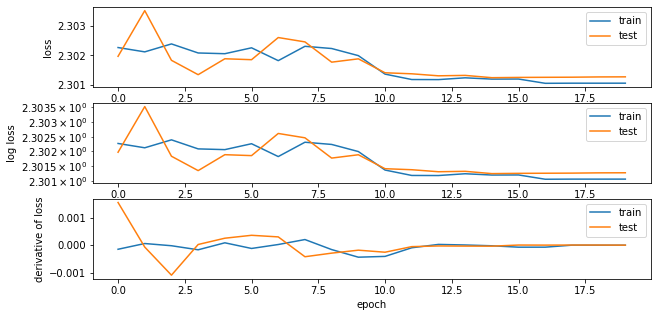

In [12]:
# plot
#  set size
plt.figure(figsize=(10, 5))
#  losses
plt.subplot(3, 1, 1)
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

#  log losses
plt.subplot(3, 1, 2)
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.yscale("log")
plt.ylabel("log loss")
plt.xlabel("epoch")
plt.legend()

#  derivative of loss
plt.subplot(3, 1, 3)
plt.plot(np.gradient(train_losses), label="train")
plt.plot(np.gradient(test_losses), label="test")
plt.ylabel("derivative of loss")
plt.xlabel("epoch")
plt.legend()

plt.show()

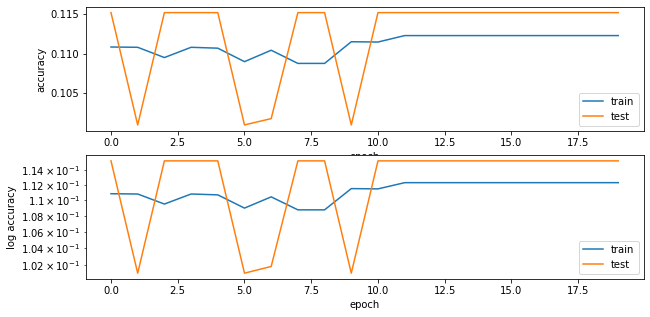

In [13]:
#  plot accuracy
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(tain_accs, label="train")
plt.plot(test_accs, label="test")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tain_accs, label="train")
plt.plot(test_accs, label="test")
plt.yscale("log")
plt.ylabel("log accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()


# evaluate the raw model

100%|██████████| 47/47 [00:00<00:00, 107.69it/s]


raw model accuracy: 0.113
raw model class accuracy: [0.0, 0.113, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


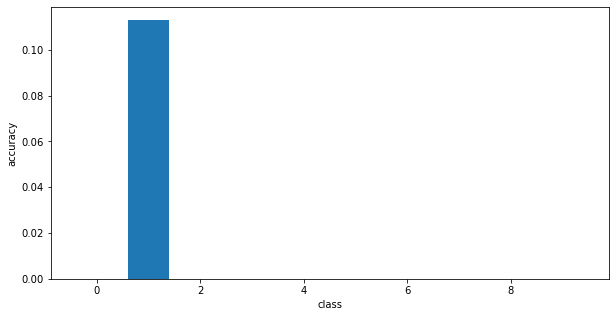

In [14]:
# evaluatre the model
convnet.load_state_dict(torch.load("convnet.pt"))
convnet.eval()

#  estimate accuracy on valid set of raw model
total_acc = 0
class_acc = [0 for _ in range(10)]
with torch.no_grad():
    for x,y in tqdm(val_loader):
        x,y = x.to(mydevice), y.to(mydevice)

        y_ = convnet(x)
        loss = critereon(y_, y)
        total_acc+= (y_.argmax(dim=1) == y).sum().item()
        for i in range(10):
            class_acc[i] += ((y_.argmax(dim=1) == y) & (y == i)).sum().item()
total_acc /= len(val_set)
class_acc = [x / len(val_set) for x in class_acc]
print(f"raw model accuracy: {total_acc}")
print(f"raw model class accuracy: {class_acc}")


#  graph class accuracy in a bar chart
plt.figure(figsize=(10, 5))
plt.bar(range(10), class_acc)
plt.xlabel("class")
plt.ylabel("accuracy")
plt.show()


# quantization

In [7]:
#  now we quantize the model
sineModel.load_state_dict(torch.load("sineModel.pt"))

#  generate random data to calibrate the model
x = torch.rand(10000, 1) * 20 - 10
y = torch.sin(x)
x = x.to(mydevice)
y = y.to(mydevice)

quantized_model = torch.quantization.quantize_dynamic(sineModel, {nn.Linear}, dtype=torch.qint8)


In [8]:
def get_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p")
    os.remove('temp.p')
    return size

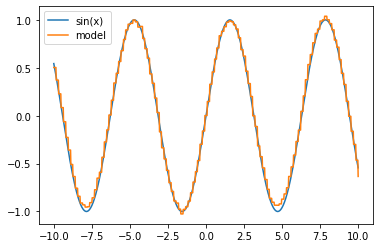

error 0.03798678144812584
error reduction 0.09959664195775986
abs error reduction 0.0342034250497818
model size 12863
quantized model size 6935
Sequential(
  (0): DynamicQuantizedLinear(in_features=1, out_features=50, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (1): Sigmoid()
  (2): DynamicQuantizedLinear(in_features=50, out_features=50, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (3): Sigmoid()
  (4): DynamicQuantizedLinear(in_features=50, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)


In [9]:
#  evaluate on a grid
x = torch.linspace(-10, 10, 1000).unsqueeze(1).to(mydevice) 
y = torch.sin(x).to(mydevice)
y_ = quantized_model(x).to(mydevice)

#  plot the results
plt.plot(x.cpu().numpy(), y.cpu().numpy(), label="sin(x)")
plt.plot(x.cpu().numpy(), y_.cpu().detach().numpy(), label="model")
plt.legend()
plt.show()

Qerror = 0

#  calculate the error
with torch.no_grad():
    Qerror = torch.mean(torch.abs(y - y_))
    print(f"error {Qerror}")

print(f"error reduction {rawerror / Qerror}")
print(f"abs error reduction {abs(rawerror - Qerror)}")
print(f"model size {get_size_of_model(sineModel)}")
print(f"quantized model size {get_size_of_model(quantized_model)}")


print(quantized_model)
# summary(quantized_model, (1,))


In [10]:
#  save the model
torch.jit.save(torch.jit.script(quantized_model), "Q_sineModel.pt")

# export to onnx

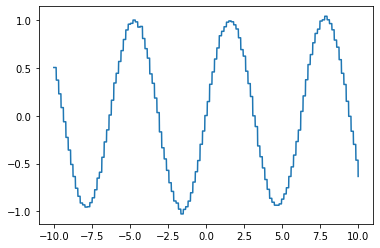

In [11]:
# load the Quantized model
Q_sineModel = torch.jit.load("Q_sineModel.pt")

# plot model
x = torch.linspace(-10, 10, 3000).unsqueeze(1).to(mydevice) #! this x is super important because it is used for the rest of the code
y = Q_sineModel(x)
plt.plot(x.cpu().detach().numpy(), y.cpu().detach().numpy())
plt.show()

In [12]:
#  model summary
print(Q_sineModel)
# summary(Q_sineModel, (1,))


RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(
    original_name=Linear
    (_packed_params): RecursiveScriptModule(original_name=LinearPackedParams)
  )
  (1): RecursiveScriptModule(original_name=Sigmoid)
  (2): RecursiveScriptModule(
    original_name=Linear
    (_packed_params): RecursiveScriptModule(original_name=LinearPackedParams)
  )
  (3): RecursiveScriptModule(original_name=Sigmoid)
  (4): RecursiveScriptModule(
    original_name=Linear
    (_packed_params): RecursiveScriptModule(original_name=LinearPackedParams)
  )
)


In [13]:
# export the model
import torch._C as _C
OperatorExportTypes = _C._onnx.OperatorExportTypes
# torch.onnx.export(torch.jit.script(Q_sineModel), x, "Q_sineModel.onnx", opset_version=11, input_names=["x"], output_names=["y"])

#  export model to onnx
torch.onnx.export(sineModel,\
     x,                         # dummy input
    "sineModel.onnx",           # save path
    opset_version=11,            # the ONNX version to export the model to
    # operator_export_type=OperatorExportTypes.ONNX_FALLTHROUGH,
    export_params=True,         # store the trained parameter weights inside the model file
    do_constant_folding=True,   # whether to execute constant folding for optimization #! am not sure what this does
    input_names=["x"],          # the model's input names
    output_names=["y"]          # the model's output names
    )



# check onnx model


In [14]:
#  load the onnx model and test
onnx_model = onnx.load("sineModel.onnx")

#  check that the IR is well formed
print("check that the IR is well formed: ")
print(onnx.checker.check_model(onnx_model))
print()
#  print a human readable representation of the graph
print(onnx.helper.printable_graph(onnx_model.graph))





check that the IR is well formed: 
None

graph torch_jit (
  %x[FLOAT, 3000x1]
) initializers (
  %0.weight[FLOAT, 50x1]
  %0.bias[FLOAT, 50]
  %2.weight[FLOAT, 50x50]
  %2.bias[FLOAT, 50]
  %4.weight[FLOAT, 1x50]
  %4.bias[FLOAT, 1]
) {
  %/0/Gemm_output_0 = Gemm[alpha = 1, beta = 1, transB = 1](%x, %0.weight, %0.bias)
  %/1/Sigmoid_output_0 = Sigmoid(%/0/Gemm_output_0)
  %/2/Gemm_output_0 = Gemm[alpha = 1, beta = 1, transB = 1](%/1/Sigmoid_output_0, %2.weight, %2.bias)
  %/3/Sigmoid_output_0 = Sigmoid(%/2/Gemm_output_0)
  %y = Gemm[alpha = 1, beta = 1, transB = 1](%/3/Sigmoid_output_0, %4.weight, %4.bias)
  return %y
}


In [15]:
#  run the model using the onnxruntime  
ort_session = onnxruntime.InferenceSession("sineModel.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}  #  x is the input that was defined before
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(sineModel(x) ), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


Exported model has been quantized with ONNXRuntime, and the result looks good!
Q ONNX model size 6252
check that the IR is well formed: 
None

graph torch_jit (
  %x[FLOAT, 3000x1]
) initializers (
  %0.bias[FLOAT, 50]
  %2.bias[FLOAT, 50]
  %4.bias[FLOAT, 1]
  %0.weight_scale[FLOAT, scalar]
  %0.weight_zero_point[UINT8, scalar]
  %0.weight_quantized[UINT8, 1x50]
  %2.weight_scale[FLOAT, scalar]
  %2.weight_zero_point[UINT8, scalar]
  %2.weight_quantized[UINT8, 50x50]
  %4.weight_scale[FLOAT, scalar]
  %4.weight_zero_point[UINT8, scalar]
  %4.weight_quantized[UINT8, 50x1]
) {
  %x_quantized, %x_scale, %x_zero_point = DynamicQuantizeLinear(%x)
  %/0/Gemm_MatMul_quant_scales_mul:0 = Mul(%x_scale, %0.weight_scale)
  %/0/Gemm_output_0_MatMul_output_quantized = MatMulInteger(%x_quantized, %0.weight_quantized, %x_zero_point, %0.weight_zero_point)
  %/0/Gemm_output_0_MatMul_output_quantized_cast_output = Cast[to = 1](%/0/Gemm_output_0_MatMul_output_quantized)
  %/0/Gemm_output_0_MatMul = Mul(

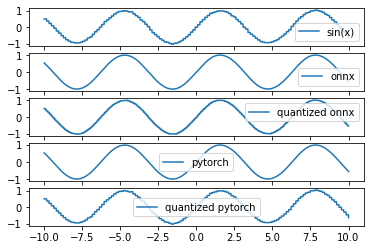

In [16]:
#  quantize the onnx model
from onnxruntime.quantization import quantize_dynamic, QuantType

quantized_model = quantize_dynamic('sineModel.onnx', 'Q_sineModel.onnx', weight_type=QuantType.QUInt8)

print("Exported model has been quantized with ONNXRuntime, and the result looks good!")
#  print size of the model
print(f"Q ONNX model size {os.path.getsize('Q_sineModel.onnx')}")

#  load the quantized onnx model and test
onnx_model = onnx.load("Q_sineModel.onnx")

#  check that the IR is well formed
print("check that the IR is well formed: ")
print(onnx.checker.check_model(onnx_model))
print()
#  print a human readable representation of the graph
print(onnx.helper.printable_graph(onnx_model.graph))

#  run the model using the onnxruntime
qort_session = onnxruntime.InferenceSession("Q_sineModel.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
qort_inputs = {qort_session.get_inputs()[0].name: to_numpy(x)}  #  x is the input that was defined before
qort_outs = qort_session.run(None, qort_inputs)

# compare ONNX Runtime and PyTorch results

rtol_ = 1e-03
atol_ = 1e-05

# plot all the results
plt.subplot(5, 1, 1)
plt.plot(x.cpu().numpy(), y.cpu().numpy(), label="sin(x)")
plt.legend()
plt.subplot(5, 1, 2)
plt.plot(x.cpu().numpy(), ort_outs[0], label="onnx")
plt.legend()
plt.subplot(5, 1, 3)
plt.plot(x.cpu().numpy(), qort_outs[0], label="quantized onnx")
plt.legend()
plt.subplot(5, 1, 4)
plt.plot(x.cpu().numpy(), to_numpy(sineModel(x)), label="pytorch")
plt.legend()
plt.subplot(5, 1, 5)
plt.plot(x.cpu().numpy(), to_numpy(Q_sineModel(x)), label="quantized pytorch")
plt.legend()


try:
    np.testing.assert_allclose(to_numpy(Q_sineModel(x) ), ort_outs[0], rtol=rtol_, atol=atol_)
    print("SUCCESS comparasion between original onnx and quantized pytorch model")
except:
    print("FAILED comparasion between original onnx and quantized pytorch model")
# print("Exported model has been tested with ONNXRuntime, and the result looks good!")
try:
    np.testing.assert_allclose(to_numpy(sineModel(x) ), ort_outs[0], rtol=rtol_, atol=atol_)
    print("SUCCESS comparasion between original onnx and original pytorch model")
except:
    print("FAILED comparasion between original onnx and original pytorch model")
# print("Exported model has been tested with ONNXRuntime, and the result looks good!")

#  compare with original onnx model
try:
    np.testing.assert_allclose(ort_outs[0], qort_outs[0], rtol=rtol_, atol=atol_)
    print("SUCCESS comparasion between original onnx and quantized onnx model")
except:
    print("FAILED comparasion between original onnx and quantized onnx model")

#  compare with original pytorch model
try:
    np.testing.assert_allclose(to_numpy(sineModel(x) ), qort_outs[0], rtol=rtol_, atol=atol_)
    print("SUCCESS comparasion between original pytorch and quantized onnx model")
except:
    print("FAILED comparasion between original pytorch and quantized onnx model")

# export to tflite

In [17]:
#  convert the onnx model to tf freezed graph

#  load the onnx model
onnx_model = onnx.load("sineModel.onnx")

#  convert the onnx model to tf
tf_rep = prepare(onnx_model)
tf_rep.export_graph("sineModel.pb")

representative_dataset = tf.data.Dataset.from_tensor_slices(x.cpu().numpy()).batch(1)
def representative_dataset_gen():
    for input_value in representative_dataset.take(100):
        # Model has only one input so each data point has one element.
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_saved_model("sineModel.pb")
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.TFLITE_BUILTINS_INT8, # enable TensorFlow Lite ops.
#   tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen

tflite_model = converter.convert()

#  save the model
open("sineModel.tflite", "wb").write(tflite_model)

2022-12-03 10:49:28.606571: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2022-12-03 10:49:28.606912: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-03 10:49:28.606939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nicolas-XPS-13-9305): /proc/driver/nvidia/version does not exist
2022-12-03 10:49:28.609086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in ot

INFO:tensorflow:Assets written to: sineModel.pb/assets


INFO:tensorflow:Assets written to: sineModel.pb/assets
2022-12-03 10:49:30.114160: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-03 10:49:30.114206: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-03 10:49:30.115087: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: sineModel.pb
2022-12-03 10:49:30.115753: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-03 10:49:30.115783: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: sineModel.pb
2022-12-03 10:49:30.117408: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2022-12-03 10:49:30.117722: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-12-03 10:49:30.193253: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on Save

5464

In [18]:
#  load the model
interpreter = tf.lite.Interpreter(model_path="Q_sineModel.tflite")
interpreter.allocate_tensors()

#  get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#  test the model
input_data = x.cpu().detach().numpy()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

#  compare the results
try:
    np.testing.assert_allclose(qort_outs[0], tflite_results, rtol=1e-03, atol=1e-05)
except:
    print("FAILED comparasion between quantized onnx and tflite model")

print("Exported model has been tested with tflite, and the result looks good!")
print("size of the tflite model is: ", os.path.getsize("Q_sineModel.tflite"))

INFO: Created TensorFlow Lite delegate for select TF ops.
INFO: TfLiteFlexDelegate delegate: 3 nodes delegated out of 80 nodes with 3 partitions.

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


FAILED comparasion between quantized onnx and tflite model
Exported model has been tested with tflite, and the result looks good!
size of the tflite model is:  22284


In [24]:
# compare all the sizes
print("size of the original pytorch model is: ", os.path.getsize("sineModel.pt"), " bytes")
print("size of the quantized pytorch model is: ", os.path.getsize("Q_sineModel.pt"), " bytes")
print("size of the original onnx model is: ", os.path.getsize("sineModel.onnx"), " bytes")
print("size of the quantized onnx model is: ", os.path.getsize("Q_sineModel.onnx"), " bytes")
# print("size of the tf model is: ", os.path.getsize("sineModel.pb"), " bytes") # there might be some problem with the tf model
print("size of the tflite model is: ", os.path.getsize("sineModel.tflite"), " bytes")


size of the original pytorch model is:  12903  bytes
size of the quantized pytorch model is:  12384  bytes
size of the original onnx model is:  11460  bytes
size of the quantized onnx model is:  6252  bytes
size of the tflite model is:  5464  bytes


In [25]:
#  compare performance
import time

load = 10000

print("for a load of ", load, " samples")

#  pytorch
start = time.time()
for i in range(load):
    to_numpy(sineModel(x))
end = time.time()
print(f" pytorch time: {(end - start):.3f} seconds")
# print("pytorch time: ", end - start, " seconds")

#  quantized pytorch
start = time.time()
for i in range(load):
    to_numpy(Q_sineModel(x))
end = time.time()
print(f" quantized pytorch time: {(end - start):.3f} seconds")
# print("quantized pytorch time: ", end - start, " seconds")

# onnx
start = time.time()
for i in range(load):
    ort_outs = ort_session.run(None, ort_inputs)
end = time.time()
print(f" onnx time: {(end - start):.3f} seconds")
# print("onnx time: ", end - start, " seconds")

#  quantized onnx
start = time.time()
for i in range(load):
    ort_outs = qort_session.run(None, qort_inputs)
end = time.time()
print(f" quantized onnx time: {(end - start):.3f} seconds")
# print("quantized onnx time: ", end - start, " seconds")

#  tflite
start = time.time()
for i in range(load):
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    tflite_results = interpreter.get_tensor(output_details[0]['index'])
end = time.time()
print(f" tflite time: {(end - start):.3f} seconds")
# print("tflite time: ", end - start, " seconds")



for a load of  10000  samples
 pytorch time: 4.136 seconds
 quantized pytorch time: 4.410 seconds
 onnx time: 3.381 seconds
 quantized onnx time: 3.621 seconds
 tflite time: 58.019 seconds


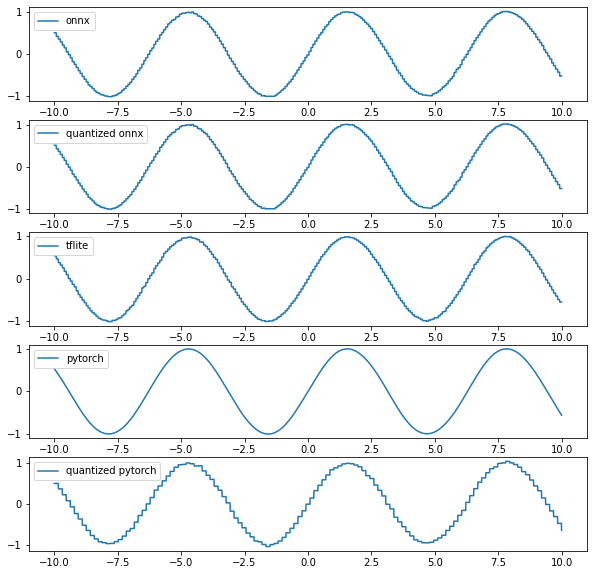

In [26]:
# compare plots
plt.figure(figsize=(10, 10))
plt.subplot(5, 1, 1)
plt.plot(x.cpu().numpy(), ort_outs[0], label="onnx")
plt.legend()
plt.subplot(5, 1, 2)
plt.plot(x.cpu().numpy(), qort_outs[0], label="quantized onnx")
plt.legend()
plt.subplot(5, 1, 3)
plt.plot(x.cpu().numpy(), tflite_results, label="tflite")
plt.legend()
plt.subplot(5, 1, 4)
plt.plot(x.cpu().numpy(), to_numpy(sineModel(x)), label="pytorch")
plt.legend()
plt.subplot(5, 1, 5)
plt.plot(x.cpu().numpy(), to_numpy(Q_sineModel(x)), label="quantized pytorch")
plt.legend()
plt.show()



In [3]:
! xxd -i sineModel.tflite > tfLite_esp32/src/sineModel.cpp
! cat tfLite_esp32/src/sineModel.cpp

unsigned char sineModel_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x78, 0x00, 0x00, 0x00, 0xd0, 0x00, 0x00, 0x00, 0xc4, 0x0d, 0x00, 0x00,
  0xd4, 0x0d, 0x00, 0x00, 0xbc, 0x14, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x3a, 0xf1, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x34, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0xa4, 0xff, 0xff, 0xff, 0x0d, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x79, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xba, 0xf2, 0xff, 0xff,
  0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x78, 0x00, 0x00, 0x00,
 